In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from celluloid import Camera
from itertools import cycle
import tikzplotlib

%run './../split_step_fourier.ipynb'
DEBUG = False

# showing figures inline
%matplotlib inline
# plotting options 
figure_size = (10, 10*np.sqrt(2))
plt.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
# parameters
f_symbol = 32e9  # symbol rate (Baud) (Symbols per second)
n_up = 10  # samples per symbol (>1 => oversampling)

r_rc = .33
syms_per_filt = 4  # symbols per filter (plus minus in both directions)
t_sample_rc, rc = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)

power = 5

# modulation scheme and constellation points
M = 2
modulation = {'0': -1, '1': 1}
n_symbol = 30 # number of symbols


# Signalfolge generieren
send_bits = np.random.choice([symbol for symbol in modulation.keys()], size=n_symbol)


# Sendesignal generieren
send_rc = generate_signal(modulation, t_sample_rc, 1/f_symbol, send_bits, rc, syms_per_filt, n_symbol, power)

# add zeros before and after signal (use samples per symbol as factor)
send_new = add_zeros(send_rc, 5 * int(1/f_symbol/t_sample_rc))

In [3]:
## Transmission
z_length = 70  # [km]
nz = 10  # steps
dz = z_length / nz  # [km]

alpha = 0.2  # Dämpfung [dB/km]
D = 17  # [ps/nm/km]
beta2 = - (D * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma = 1.3 # [1/W/km]

output = splitstepfourier(send_new, t_sample_rc, dz, nz, alpha, beta2, gamma, True)

Text(0.5, 0, '$t$ [s]')

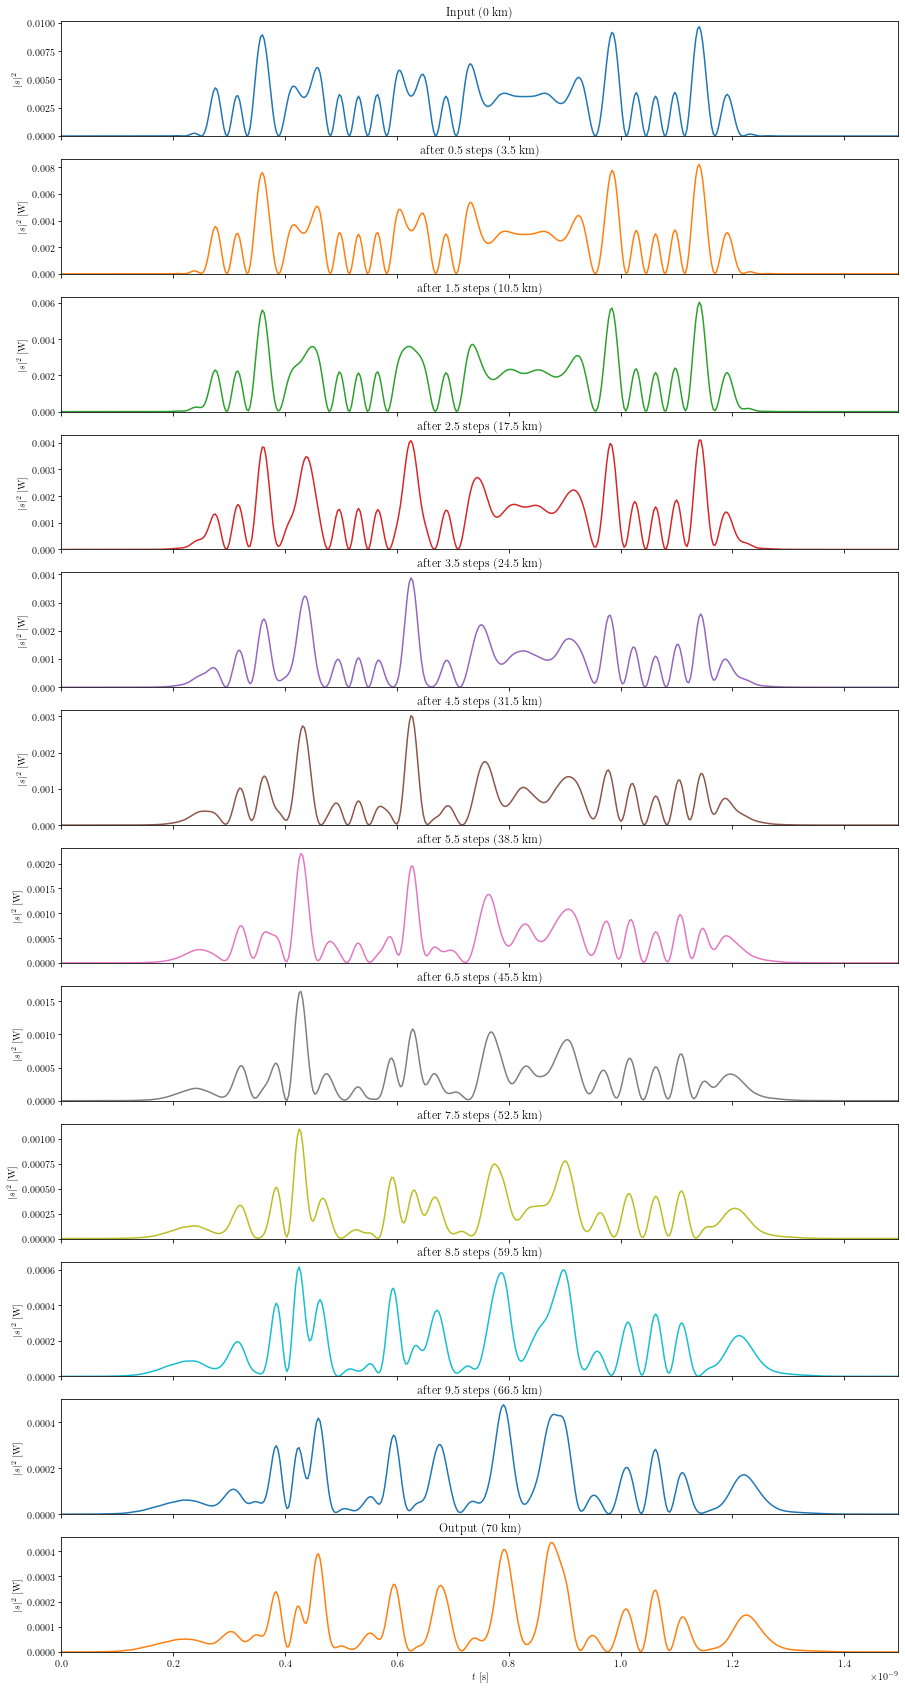

In [4]:
fig1, ax1 = plt.subplots(len(output)+1, figsize=(15,30), sharex=True)

colors = cycle(list(mcolors.TABLEAU_COLORS))
counter = 0

x_vals = np.arange(send_new.size)*t_sample_rc
xmin = np.amin(x_vals)
xmax = np.amax(x_vals)

ax1[counter].plot(x_vals, np.square(np.abs(send_new)), label='0', color=next(colors))
ax1[counter].set_xlim(xmin, xmax)
ax1[counter].set_ylim(bottom=0)
ax1[counter].set_title("Input (0 km)")
ax1[counter].set_ylabel("$|s|^2$")
counter += 1

for key, val in output.items():
    ax1[counter].plot(x_vals, np.square(np.abs(val)), label=key, color=next(colors))
    ax1[counter].set_ylim(bottom=0)
    ax1[counter].set_title(f"after {key} steps ({float(key)*dz} km)")
    ax1[counter].set_ylabel("$|s|^2$ [W]")
    counter += 1

ax1[counter-1].set_title(f"Output ({z_length} km)")
ax1[counter-1].set_xlabel("$t$ [s]")

In [5]:
## Transmission
z_length = 70  # [km]
nz = 10  # steps
dz = z_length / nz  # [km]

alpha = 0  # Dämpfung [dB/km]
D = 17  # [ps/nm/km]
beta2 = - (D * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma = 1.3 # [1/W/km]

output2 = splitstepfourier(send_new, t_sample_rc, dz, nz, alpha, beta2, gamma, True)

0.015075729922070843


Text(0.5, 0, '$t$ [s]')

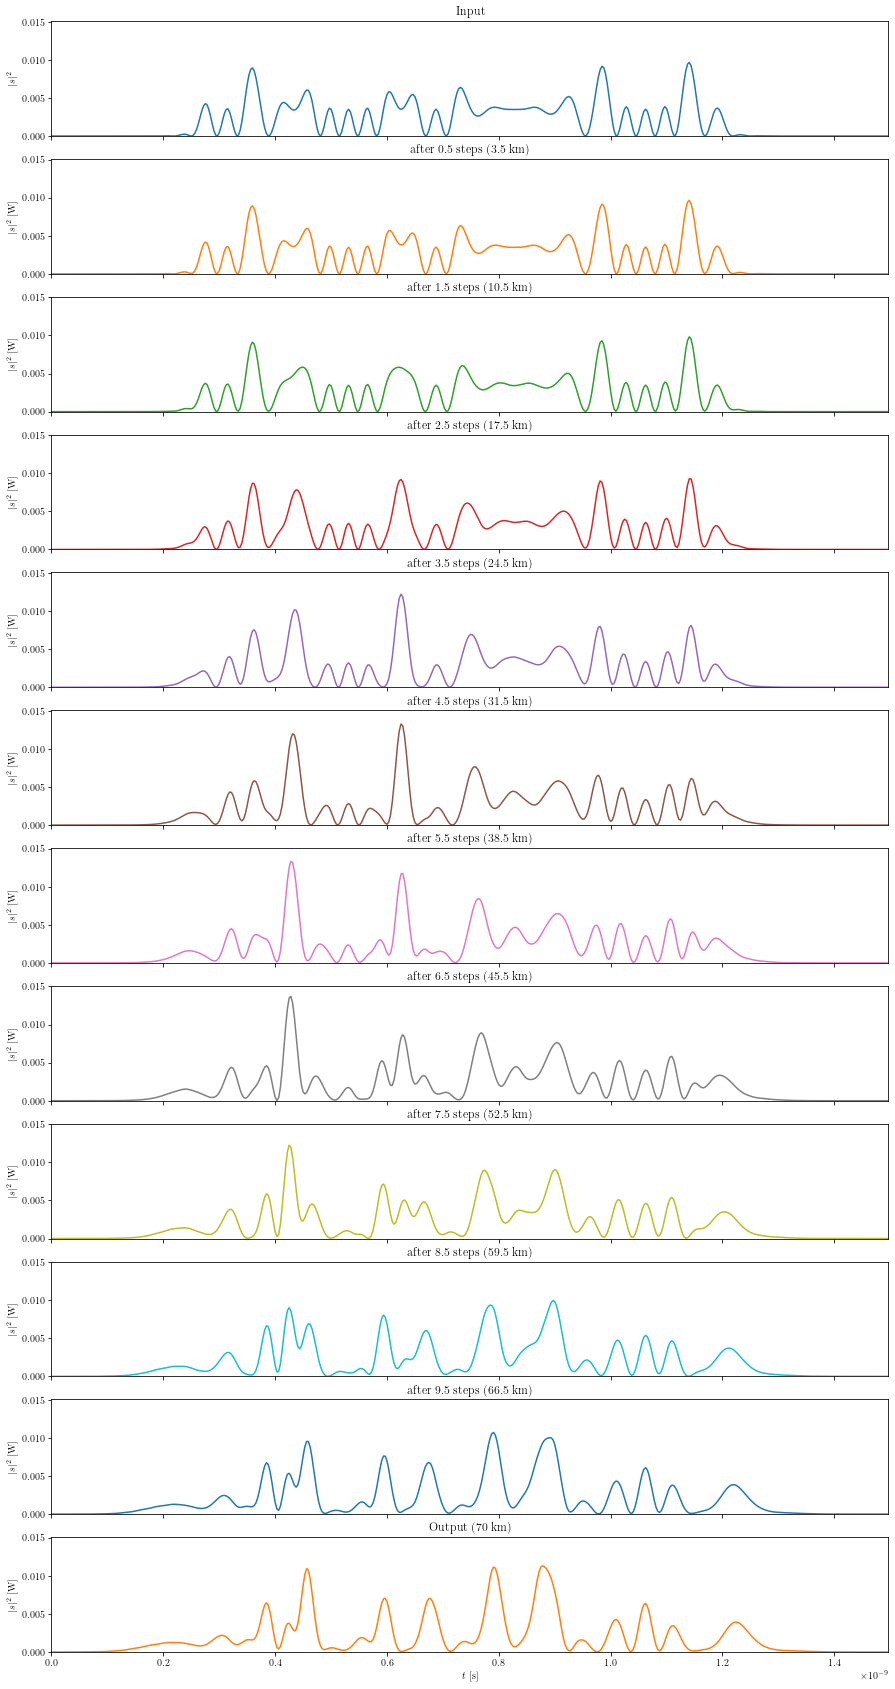

In [6]:
fig2, ax2 = plt.subplots(len(output)+1, figsize=(15,30), sharex=True)

colors = cycle(list(mcolors.TABLEAU_COLORS))
counter = 0

all_vals = np.square(np.abs(np.asarray([val for val in output2.values()]).flatten()))
ymin = np.amin(all_vals)
ymax = np.amax(all_vals)*1.1
print(ymax)
x_vals = np.arange(send_new.size)*t_sample_rc
xmin = np.amin(x_vals)
xmax = np.amax(x_vals)

ax2[counter].plot(x_vals, np.square(np.abs(send_new)), label='0', color=next(colors))
ax2[counter].set_xlim(xmin, xmax)
ax2[counter].set_ylim(ymin, ymax)
ax2[counter].set_title(f"Input")
ax2[counter].set_ylabel("$|s|^2$")
counter += 1

for key, val in output2.items():
    ax2[counter].plot(x_vals, np.square(np.abs(val)), label=key, color=next(colors))
    ax2[counter].set_xlim(xmin, xmax)
    ax2[counter].set_ylim(ymin, ymax)
    ax2[counter].set_title(f"after {key} steps ({float(key)*dz} km)")
    ax2[counter].set_ylabel("$|s|^2$ [W]")
    counter += 1
    
ax2[counter-1].set_title(f"Output ({z_length} km)")
ax2[counter-1].set_xlabel("$t$ [s]")

In [7]:
# parameters
f_symbol2 = 32e9  # symbol rate (Baud) (Symbols per second)
n_up2 = 10  # samples per symbol (>1 => oversampling)

r_rc2 = .33
syms_per_filt2 = 4  # symbols per filter (plus minus in both directions)
t_sample_rc2, rc2 = get_rc_ir(syms_per_filt2, r_rc2, f_symbol2, n_up2)

power2 = 5

# modulation scheme and constellation points
M2 = 2
modulation2 = {'0': -1, '1': 1}
n_symbol2 = 10 # number of symbols

# Signalfolge generieren
send_bits2 = np.random.choice([symbol for symbol in modulation2.keys()], size=n_symbol2)

# Sendesignal generieren
send_rc2 = generate_signal(modulation2, t_sample_rc2, 1/f_symbol2, send_bits2, rc2, syms_per_filt2, n_symbol2, power2)

# add zeros before and after signal (use samples per symbol as factor)
send_new2 = add_zeros(send_rc2, 5 * int(1/f_symbol2/t_sample_rc2))

In [8]:
## Transmission
z_length2 = 70  # [km]
nz2 = 100  # steps
dz2 = z_length2 / nz2  # [km]

alpha2 = 0  # Dämpfung [dB/km]
D2 = 17  # [ps/nm/km]
beta22 = - (D2 * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma2 = 1.3 # [1/W/km]

output3 = splitstepfourier(send_new2, t_sample_rc2, dz2, nz2, alpha2, beta22, gamma2, True)

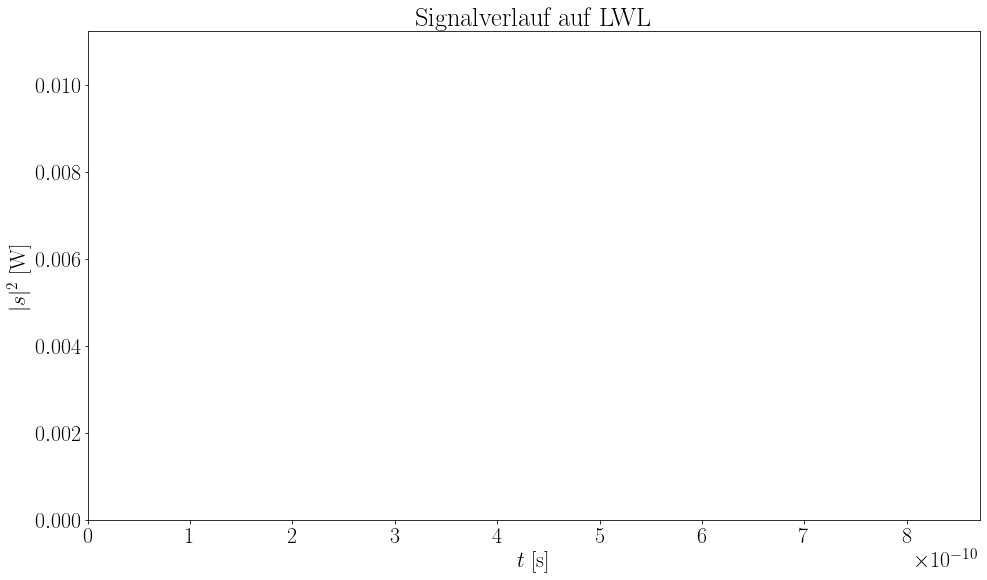

In [9]:
## Animated Plot
plt.rcParams.update({'font.size': 22})

all_vals2 = np.square(np.abs(np.asarray([val for val in output3.values()]).flatten()))
ymin2 = np.amin(all_vals2)
ymax2 = np.amax(all_vals2)*1.1

x_vals2 = np.arange(send_new2.size)*t_sample_rc
xmin2 = np.amin(x_vals2)
xmax2 = np.amax(x_vals2)

fig = plt.figure(figsize=(16,9))
camera = Camera(fig)

p = plt.plot(x_vals2, np.square(np.abs(send_new2)), label='Schritt 0 (0 km)', color='tab:blue')
plt.xlim(xmin2,xmax2)
plt.ylim(ymin2,ymax2)
plt.title("Signalverlauf auf LWL")
plt.ylabel("$|s|^2$ [W]")
plt.xlabel("$t$ [s]")
plt.legend(p, ['Schritt 0.0'])
plt.savefig('../../../bachelorarbeit-folien/abschlussvortrag/images/fiber_propagation_wallpaper_noalpha.pdf')
camera.snap()

for key,val in output3.items():
    p = plt.plot(x_vals2, np.square(np.abs(val)), color='tab:blue')
    plt.xlim(xmin2,xmax2)
    plt.ylim(ymin2,ymax2)
    plt.title("Signalverlauf auf LWL")
    plt.ylabel("$|s|^2$ [W]")
    plt.xlabel("$t$ [s]")
    plt.legend(p, [f'Schritt {key}'])
    camera.snap()

animation = camera.animate(interval=200)

In [10]:
output_fname = "fiber_propagation"
output_path = "../../../bachelorarbeit-ausarbeitung/figures/plots/"

tikzplotlib.save(f'{output_path}{output_fname}.tex', figure=fig1, wrap=False, add_axis_environment=False, externalize_tables=True, override_externals=True)
tikzplotlib.save(f'{output_path}{output_fname}_noalpha.tex', figure=fig2, wrap=False, add_axis_environment=False, externalize_tables=True, override_externals=True)

fig1.savefig(f"{output_path}{output_fname}.pdf", bbox_inches='tight')
fig2.savefig(f"{output_path}{output_fname}_noalpha.pdf", bbox_inches='tight')

animation.save(f'../../../bachelorarbeit-folien/abschlussvortrag/video/{output_fname}_animated_noalpha.mp4', dpi=96)